# Figure X. SUPP Calculating model efficacy parameters

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from scipy import integrate as sp
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import bisect
import time

### 1. Set up model
Parameters:

In [2]:
# MOSQUITO
alphaO=0.5  # rate that eggs hatch into larvae
alphaL=0.18  # rate that larvae pupate
alphaP=1  # rate that pupae eclose
phi=500*(1/14)    # number eggs laid per mosquito per day
muO=0.01    # daily death rate of eggs
muL=0.1*alphaL    # daily death rate of larvae
muP=0.1*alphaP     # pupae death rate
muM=1/14     # adult mosquito death rate
muF=1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA=1   # determines the density at which mortality remains proportionate
BB=0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI=0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT=0 #0.11    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c=0.5      # mating competitiveness of released wolbachia males
cv=1   # coverage of adulticide - 0.128 recovers 80% within 3 weeks from one pulse
e=1.2      # relative mortality of wolbachia adults compared to wild adults
RR=0.02915       # release ratio of wolbachia eggs to wild type eggs
RRsupp=1      # release ratio of wolbachia eggs to wild type eggs for suppression techniques

Initial conditions:
(equilibrium values previously defined in Supp)

In [3]:
O0=15947.608023052446
OW0=0
rOW0=0
OS0=0
L0=40271.71074193975
LW0=0
rLW0=0
LS0=0
P0=32.67541200187585
PW0=0
rPW0=0
PS0=0
M0=228.72754035145144
MW0=0
MS0=0
F0=228.72754035145144
FW0=0

Wolbachia release function:

In [4]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return 0 #O0
    else:
        return 0

Suppression functions:

In [5]:
# IIT

def IIT(t, releasenumber=1, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0
        
RRsupp = 10.5

In [6]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

    
#RRsupp = 10.7 #1.865

In [7]:
# Environmental management

start_em=193
stop_em=200
em_eff= 1 #0.526

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [8]:
# Larvicides (e.g. guppies)

start_lv=193
stop_lv=200
lv_eff= 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

# to reach a new equilibrium:
# based on pupae being 99 at eq - 80% 19.8 / 50% 49.5 / 20% 79.2 / 44% 65.34 / 70% 29.7
# default 1 / 19.2(80%) / 7.6(50%) / 2.97(20%) / 6.42(44% literature) / 5.8(70% old)
# parameter that kills proportion of pupae (wild and wol)

# based on pupae being 33 at eq - 44% = 4.03

In [9]:
# Adulticide

h = start_wol

def ad(t):    
    eff = 0 #4.9 #0.455
    if round(t) < h:
        return 0
    elif round(t) > h+0.01:
        return 0
    else:
        return eff

# NEW efficacy (fixed brackets)
# 4.9 = 90%
    
# efficacy
# 3 = ~90% | 1.9 = ~80% | 1.38 = ~70% | 1.03 = ~60% | 0.77 = ~50%
# 0.56 = ~40% | 0.39 = ~30% | 0.24 = ~20% | 0.11 = ~10%

Model:

In [10]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch):
    
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = y
    
    #MOSQUITOES
    
    allfemales = 1+F+FW
    allmales = 1+M+MW+(MS*c)
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = em(t) * phi * F_nothing * M_nothing/allmales - alphaO*O - lv(t)*muO*O # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = em(t) * phi * F_wol * (M+MW)/allmales - alphaO*OW - lv(t)*muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW
    dOSdt = phi * allfemales * (MS*c)/allmales - alphaO*OS - muO*OS
    
    #Larvae
    dLdt =  alphaO*O - alphaL*L - lv(t)*muL*L
    dLWdt = alphaO*OW - alphaL*LW - lv(t)*muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    dLSdt = switch*alphaO*OS - alphaL*LS - muL*LS
    
    #Pupae 
    dPdt =  alphaL*(L/(1+((AA*(L+LW+LS))**BB))) - alphaP*P - lv(t)*muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW+LS))**BB))) - alphaP*PW - lv(t)*muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    dPSdt = alphaL*(LS/(1+((AA*(L+LW+LS))**BB))) - alphaP*PS - muP*PS
        
    #Adult
    dMdt =  .5*alphaP*P - muM*M - ad(t)*M*cv
    dMWdt = IIT(t)*RRsupp + .5*alphaP*(PW+rPW) - muM*1.2*MW - ad(t)*MW*cv
    dMSdt = SIT(t)*RRsupp + .5*alphaP*PS - muM*1.2*MS
    
    dFdt =  .5*alphaP*P - muF*F - ad(t)*F*cv
    dFWdt = .5*alphaP*(PW+rPW) - muF*1.2*FW - ad(t)*FW*cv

    return dOdt, dOWdt, drOWdt, dOSdt, dLdt, dLWdt, drLWdt, dLSdt, dPdt, dPWdt, drPWdt, dPSdt, dMdt, dMWdt, dMSdt, dFdt, dFWdt

Model prerequisites:

In [11]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # initial condition vector

Run model:

In [12]:
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

Visual check all suppression and Wolbachia functions are switched off:
(should see horizontal lines)

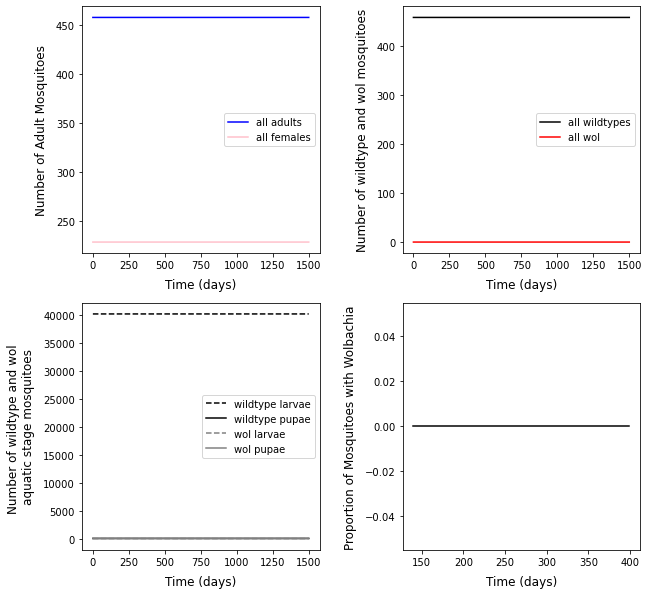

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes",fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW, 'red', label='all wol')
ax2.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes",fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes",fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia",fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

#plt.savefig('wolAedesDemo-KT', dpi=300, facecolor='w', edgecolor='w',
#        orientation='portrait', format=None, transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

### 2. Calculating efficacy parameters

#### IIT:
(run for 5 weeks)

In [14]:
# switch on

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

In [15]:
# efficacy calculated as uninfected adult minimum population reached

start_time = time.time()

lower_bounds = [19.950,49.950,79.950]
upper_bounds = [20.049,50.049,80.049]

IIT_decrease = []
IIT_eff= []
eq = 457.4550807029029
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for i in list(range(0,3)):

    for j in list(np.linspace(start,end,nums)):
        
        RRsupp = j
    
        # run model
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
        # calculate efficacy
        pop_min = min(M)+min(F)
        prop_decrease_min = (1-(pop_min/eq))*100
        
        # store results
        if lower_bounds[i] < prop_decrease_min < upper_bounds[i]:   
            IIT_decrease.append(prop_decrease_min)
            IIT_eff.append(round(j,3))
            break
    
    start = j
    nums = int(((end-start)*1000)+1)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 4.62 minutes


In [16]:
IIT_df = pd.DataFrame({'Target efficacy': [20,50,80]})
IIT_df['Achieved efficacy'] = IIT_decrease
IIT_df['RRsupp value'] = IIT_eff
IIT_df['Maximum delayed efficacy'] = ['NaN', 'NaN', 'NaN']

IIT_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20,19.979565,0.155,NaN
1,50,49.950855,0.640,NaN
2,80,79.952078,3.054,NaN


In [17]:
# efficacy calculated as uninfected adult population reached 5 weeks after the end of 5 week suppression period

lower_bounds = 59.950
upper_bounds = 60.049
five_week = start_wol+35

eq = 457.4550807029029
start = list(IIT_df.loc[IIT_df['Target efficacy'] == 50, 'RRsupp value'])
end = list(IIT_df.loc[IIT_df['Target efficacy'] == 80, 'RRsupp value'])
nums = int(round((end[0]-start[0])*1000)+1)

for j in list(np.linspace(start[0],end[0],nums)):
        
    RRsupp = j
    
    # run model
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
    # calculate efficacy
    pop_effect = M[five_week]+F[five_week]
    prop_decrease = (1-(pop_effect/eq))*100
    pop_min = min(M)+min(F)
    prop_decrease_min = (1-(pop_min/eq))*100
        
    # store results
    if lower_bounds < prop_decrease < upper_bounds:
        lit_eff = {'Target efficacy':60, 'Achieved efficacy':prop_decrease, 'RRsupp value':round(j,3), 'Maximum delayed efficacy':prop_decrease_min}
        break

In [18]:
IIT_df = IIT_df.append(lit_eff, ignore_index=True)

IIT_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20.0,19.979565,0.155,NaN
1,50.0,49.950855,0.640,NaN
2,80.0,79.952078,3.054,NaN
3,60.0,59.969591,1.152,63.276652


In [21]:
# efficacy calculated as uninfected adult population reached 10 weeks after the end of 5 week suppression period

start_time = time.time()

lower_bounds = 94.950
upper_bounds = 95.049
ten_week = start_wol+70

eq = 457.4550807029029
start = list(IIT_df.loc[IIT_df['Target efficacy'] == 80, 'RRsupp value'])
end = 50
nums = int(round((end-start[0])*1000)+1)

for j in list(np.linspace(start[0],end,nums)):
        
    RRsupp = j
    
    # run model
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
    # calculate efficacy
    pop_effect = M[ten_week]+F[ten_week]
    prop_decrease = (1-(pop_effect/eq))*100
    pop_min = min(M)+min(F)
    prop_decrease_min = (1-(pop_min/eq))*100
        
    # store results
    if lower_bounds < prop_decrease < upper_bounds:
        IIT_tenweek = {'Target efficacy':95, 'Achieved efficacy':prop_decrease, 'RRsupp value':round(j,3), 'Maximum delayed efficacy':prop_decrease_min}
        break
        
current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

In [22]:
IIT_df = IIT_df.append(IIT_tenweek, ignore_index=True)

IIT_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20.0,19.979565,0.155,NaN
1,50.0,49.950855,0.640,NaN
2,80.0,79.952078,3.054,NaN
3,60.0,59.969591,1.152,63.276652
4,95.0,94.950023,42.486,95.498459


In [23]:
#save dataframe
IIT_df.to_csv('IIT_df.csv')

In [24]:
# switch off again

def IIT(t, releasenumber=1, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

#### SIT:
(run for 5 weeks)

In [74]:
# switch on

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0 
    else:
        return 0

In [76]:
# efficacy calculated as uninfected adult minimum population reached

start_time = time.time()

lower_bounds = [19.950,49.950,79.950]
upper_bounds = [20.049,50.049,80.049]
five_week = start_wol+35

SIT_decrease = []
SIT_eff = []
SIT_decrease_max = []
eq = 457.4550807029029
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for i in list(range(0,3)):

    for j in list(np.linspace(start,end,nums)):
        
        RRsupp = j
    
        # run model
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
        # calculate efficacy
        pop_min = min(M)+min(F)
        prop_decrease_min = (1-(pop_min/eq))*100
        
        # store results
        if lower_bounds[i] < prop_decrease_min < upper_bounds[i]:   
            SIT_decrease.append(prop_decrease_min)
            SIT_eff.append(round(j,3))
            break     
    
    start = j
    nums = int(((end-start)*1000)+1)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 7.89 minutes


In [77]:
SIT_df = pd.DataFrame({'Target efficacy': [20,50,80]})
SIT_df['Achieved efficacy'] = SIT_decrease
SIT_df['RRsupp value'] = SIT_eff

SIT_df

,Target efficacy,Achieved efficacy,RRsupp value
0,20,19.997650,0.305
1,50,49.959542,1.236
2,80,79.951665,5.360


In [78]:
#save dataframe
SIT_df.to_csv('SIT_df.csv')

In [79]:
# switch off again

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

#### RIDL:
(run for 5 weeks)

In [42]:
# switch on

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

In [35]:
# efficacy calculated as uninfected adult minimum population reached

start_time = time.time()

lower_bounds = [19.950,49.950,79.950]
upper_bounds = [20.049,50.049,80.049]

RIDL_decrease = []
RIDL_eff= []
eq = 457.4550807029029
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for i in list(range(0,3)):

    for j in list(np.linspace(start,end,nums)):
        
        RRsupp = j
    
        # run model
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
        # calculate efficacy
        pop_min = min(M)+min(F)
        prop_decrease_min = (1-(pop_min/eq))*100
        
        # store results
        if lower_bounds[i] < prop_decrease_min < upper_bounds[i]:   
            RIDL_decrease.append(prop_decrease_min)
            RIDL_eff.append(round(j,3))
            break
    
    start = j
    nums = int(((end-start)*1000)+1)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 1.41 minutes


In [36]:
RIDL_df = pd.DataFrame({'Target efficacy': [20,50,80]})
RIDL_df['Achieved efficacy'] = RIDL_decrease
RIDL_df['RRsupp value'] = RIDL_eff
RIDL_df['Maximum delayed efficacy'] = ['NaN', 'NaN', 'NaN']

RIDL_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20,19.960353,0.104,NaN
1,50,50.013914,0.346,NaN
2,80,79.967717,0.950,NaN


In [37]:
# efficacy calculated as uninfected adult population reached 10 weeks after the end of 5 week suppression period

start_time = time.time()

lower_bounds = 44.950
upper_bounds = 45.049
five_week = start_wol+35

eq = 457.4550807029029
start = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 20, 'RRsupp value'])
end = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 50, 'RRsupp value'])
nums = int(round((end[0]-start[0])*1000)+1)

for j in list(np.linspace(start[0],end[0],nums)):
        
    RRsupp = j
    
    # run model
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
    # calculate efficacy
    pop_effect = M[five_week]+F[five_week]
    prop_decrease = (1-(pop_effect/eq))*100
    pop_min = min(M)+min(F)
    prop_decrease_min = (1-(pop_min/eq))*100
        
    # store results
    if lower_bounds < prop_decrease < upper_bounds:
        lit_eff = {'Target efficacy':45, 'Achieved efficacy':prop_decrease, 'RRsupp value':round(j,3), 'Maximum delayed efficacy':prop_decrease_min}
        break

In [38]:
RIDL_df = RIDL_df.append(lit_eff, ignore_index=True)

RIDL_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20.0,19.960353,0.104,NaN
1,50.0,50.013914,0.346,NaN
2,80.0,79.967717,0.950,NaN
3,45.0,44.998185,0.305,46.117523


In [46]:
# efficacy calculated as uninfected adult population reached 5 weeks after the end of 5 week suppression period

start_time = time.time()

lower_bounds = 69.950
upper_bounds = 70.049
ten_week = start_wol+70

eq = 457.4550807029029
start = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 50, 'RRsupp value'])
end = 50
nums = int(round((end-start[0])*1000)+1)

for j in list(np.linspace(start[0],end,nums)):
        
    RRsupp = j
    
    # run model
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
    # calculate efficacy
    pop_effect = M[ten_week]+F[ten_week]
    prop_decrease = (1-(pop_effect/eq))*100
    pop_min = min(M)+min(F)
    prop_decrease_min = (1-(pop_min/eq))*100
        
    # store results
    if lower_bounds < prop_decrease < upper_bounds:
        RIDL_tenweek = {'Target efficacy':70, 'Achieved efficacy':prop_decrease, 'RRsupp value':round(j,3), 'Maximum delayed efficacy':prop_decrease_min}
        break
        
current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 0.91 minutes


In [48]:
RIDL_df = RIDL_df.append(RIDL_tenweek, ignore_index=True)

RIDL_df

,Target efficacy,Achieved efficacy,RRsupp value,Maximum delayed efficacy
0,20.0,19.960353,0.104,NaN
1,50.0,50.013914,0.346,NaN
2,80.0,79.967717,0.950,NaN
3,45.0,44.998185,0.305,46.117523
4,70.0,69.957318,0.957,80.143844


In [49]:
#save dataframe
RIDL_df.to_csv('RIDL_df.csv')

In [50]:
# switch off again

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=1, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

#### Environmental management:
Efficacy parameter is a direct application of literature values; observed reduction is applied as the proportion of eggs which are able to be laid.

In [95]:
EM_df = pd.DataFrame({'Target efficacy': [20,50,80,47.4],
                       'Efficacy parameter': [0.8,0.5,0.2,0.526]})
EM_df

,Target efficacy,Efficacy parameter
0,20.0,0.800
1,50.0,0.500
2,80.0,0.200
3,47.4,0.526


In [96]:
#save dataframe
EM_df.to_csv('EM_df.csv')

#### Larvicides:
(calculated at new pupal equilibrium)

In [98]:
# Larvicides (e.g. guppies)

start_lv = start_wol #arbitrary
stop_lv = 1500 #end of model
lv_eff = 1

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [99]:
start_time = time.time()

lower_bounds = [19.950,43.950,49.950,79.950]
upper_bounds = [20.049,44.049,50.049,80.049]

LV_decrease = []
LV_eff = []
p_eq = 32.67541200187585
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for i in list(range(0,4)):

    for j in list(np.linspace(start,end,nums)):
        
        lv_eff = j
    
        # run model
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
        # calculate efficacy
        pop_min = P[1500]
        prop_decrease = (1-(pop_min/p_eq))*100
        
        # store results
        if lower_bounds[i] < prop_decrease < upper_bounds[i]:   
            LV_decrease.append(prop_decrease)
            LV_eff.append(round(j,3))
            break
    
    start = j
    nums = int(((end-start)*1000)+1)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 8.02 minutes


In [100]:
LV_df = pd.DataFrame({'Target efficacy': [20,45,50,80]})
LV_df['Model efficacy'] = LV_decrease
LV_df['Efficacy parameter'] = LV_eff

LV_df

,Target efficacy,Model efficacy,Efficacy parameter
0,20,19.957080,1.777
1,45,43.952347,3.125
2,50,49.960003,3.582
3,80,79.952713,7.803


In [101]:
#save dataframe
LV_df.to_csv('LV_df.csv')

In [102]:
# switch off again

lv_eff= 1

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

#### Adulticide:
(run for 1 week)

In [244]:
# Adulticide

h = start_wol #arbitrary
ad_eff = 1 #arbitrary

def ad(t):
    if round(t) < h:
        return 0
    elif round(t) > h+0.01:
        return 0
    else:
        return ad_eff

In [245]:
# efficacy calculated as adult minimum population reached

start_time = time.time()

lower_bounds = [19.950,49.950,79.950,93.950]
upper_bounds = [20.049,50.049,80.049,94.049]

AD_decrease = []
AD_eff = []
eq = 457.4550807029029
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for i in list(range(0,4)):

    for j in list(np.linspace(start,end,nums)):
        
        ad_eff = j
    
        # run model
        ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
        O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
        # calculate efficacy
        pop_min = min(M)+min(F)
        prop_decrease = (1-(pop_min/eq))*100
        
        # store results
        if lower_bounds[i] < prop_decrease < upper_bounds[i]:   
            AD_decrease.append(prop_decrease)
            AD_eff.append(round(j,3))
            break
    
    start = j
    nums = int(((end-start)*1000)+1)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time/60,2),'minutes')

processing time: 4.6 minutes


In [246]:
AD_df = pd.DataFrame({'Target efficacy': [20,50,80,94]})
AD_df['Achieved efficacy'] = AD_decrease
AD_df['Efficacy parameter'] = AD_eff
AD_df['Coverage value'] = [1,1,1,'NaN']

AD_df

,Target efficacy,Achieved efficacy,Efficacy parameter,Coverage value
0,20,19.975564,0.241,1
1,50,49.981922,0.764,1
2,80,79.962323,1.893,1
3,94,93.950529,4.441,NaN


In [248]:
# efficacy set to 94%, coverage value calculated as adult population recovered to 80% 3 weeks after end of suppression period

ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
lower_bounds = 79.950
upper_bounds = 80.049
three_week = start_wol+21

AD_recovery = []
AD_eff = []
eq = 457.4550807029029
start = 0
end = 50 #defines range of values to explore
nums = int(((end-start)*1000)+1)

for j in list(np.linspace(start,end,nums)):
    
    cv = j
    
    # run model
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T
    
    # calculate recovery
    pop_effect = M[three_week] + F[three_week]
    prop_recovery = (pop_effect/eq)*100
        
    # store results
    if lower_bounds < prop_recovery < upper_bounds:         
        AD_df['Coverage value'] = AD_df['Coverage value'].replace(['NaN'], j)
        break

In [249]:
AD_df

,Target efficacy,Achieved efficacy,Efficacy parameter,Coverage value
0,20,19.975564,0.241,1.000
1,50,49.981922,0.764,1.000
2,80,79.962323,1.893,1.000
3,94,93.950529,4.441,0.141


In [250]:
#save dataframe
AD_df.to_csv('AD_df.csv')

In [251]:
# switch off again

h = start_wol
eff = 0

def ad(t):
    if round(t) < h:
        return 0
    elif round(t) > h+0.01:
        return 0
    else:
        return eff